In [26]:
import numpy as np
import xarray as xr
from pathlib import Path
import os

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
from matplotlib.pyplot import get_cmap
import regionmask

In [27]:
fig_dir = '/home/548/cd3022/aus-historical-solar-droughts/figs/metrics/'
os.makedirs(fig_dir, exist_ok=True)

In [2]:
variables = ['num', 'dur', 'freq', 'mean', 'amp']
seasons = ['summer', 'autumn', 'winter', 'spring']
file_path = Path('/g/data/er8/users/cd3022/solar_drought/regional_metrics/')

# Dictionary to hold each variable's DataArray
var_dict = {}

for var in variables:
    season_data = []
    for season in seasons:
        ds = xr.open_dataset(file_path / f'{var}_{season}.nc')
        da = next(iter(ds.data_vars.values()))
        da = da.expand_dims(season=[season])  # Add season as a coordinate
        season_data.append(da)
    var_dict[var] = xr.concat(season_data, dim='season')

# Combine into one Dataset
ds = xr.Dataset(var_dict)

/jobfs/142651263.gadi-pbs/ipykernel_21130/3057241237.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


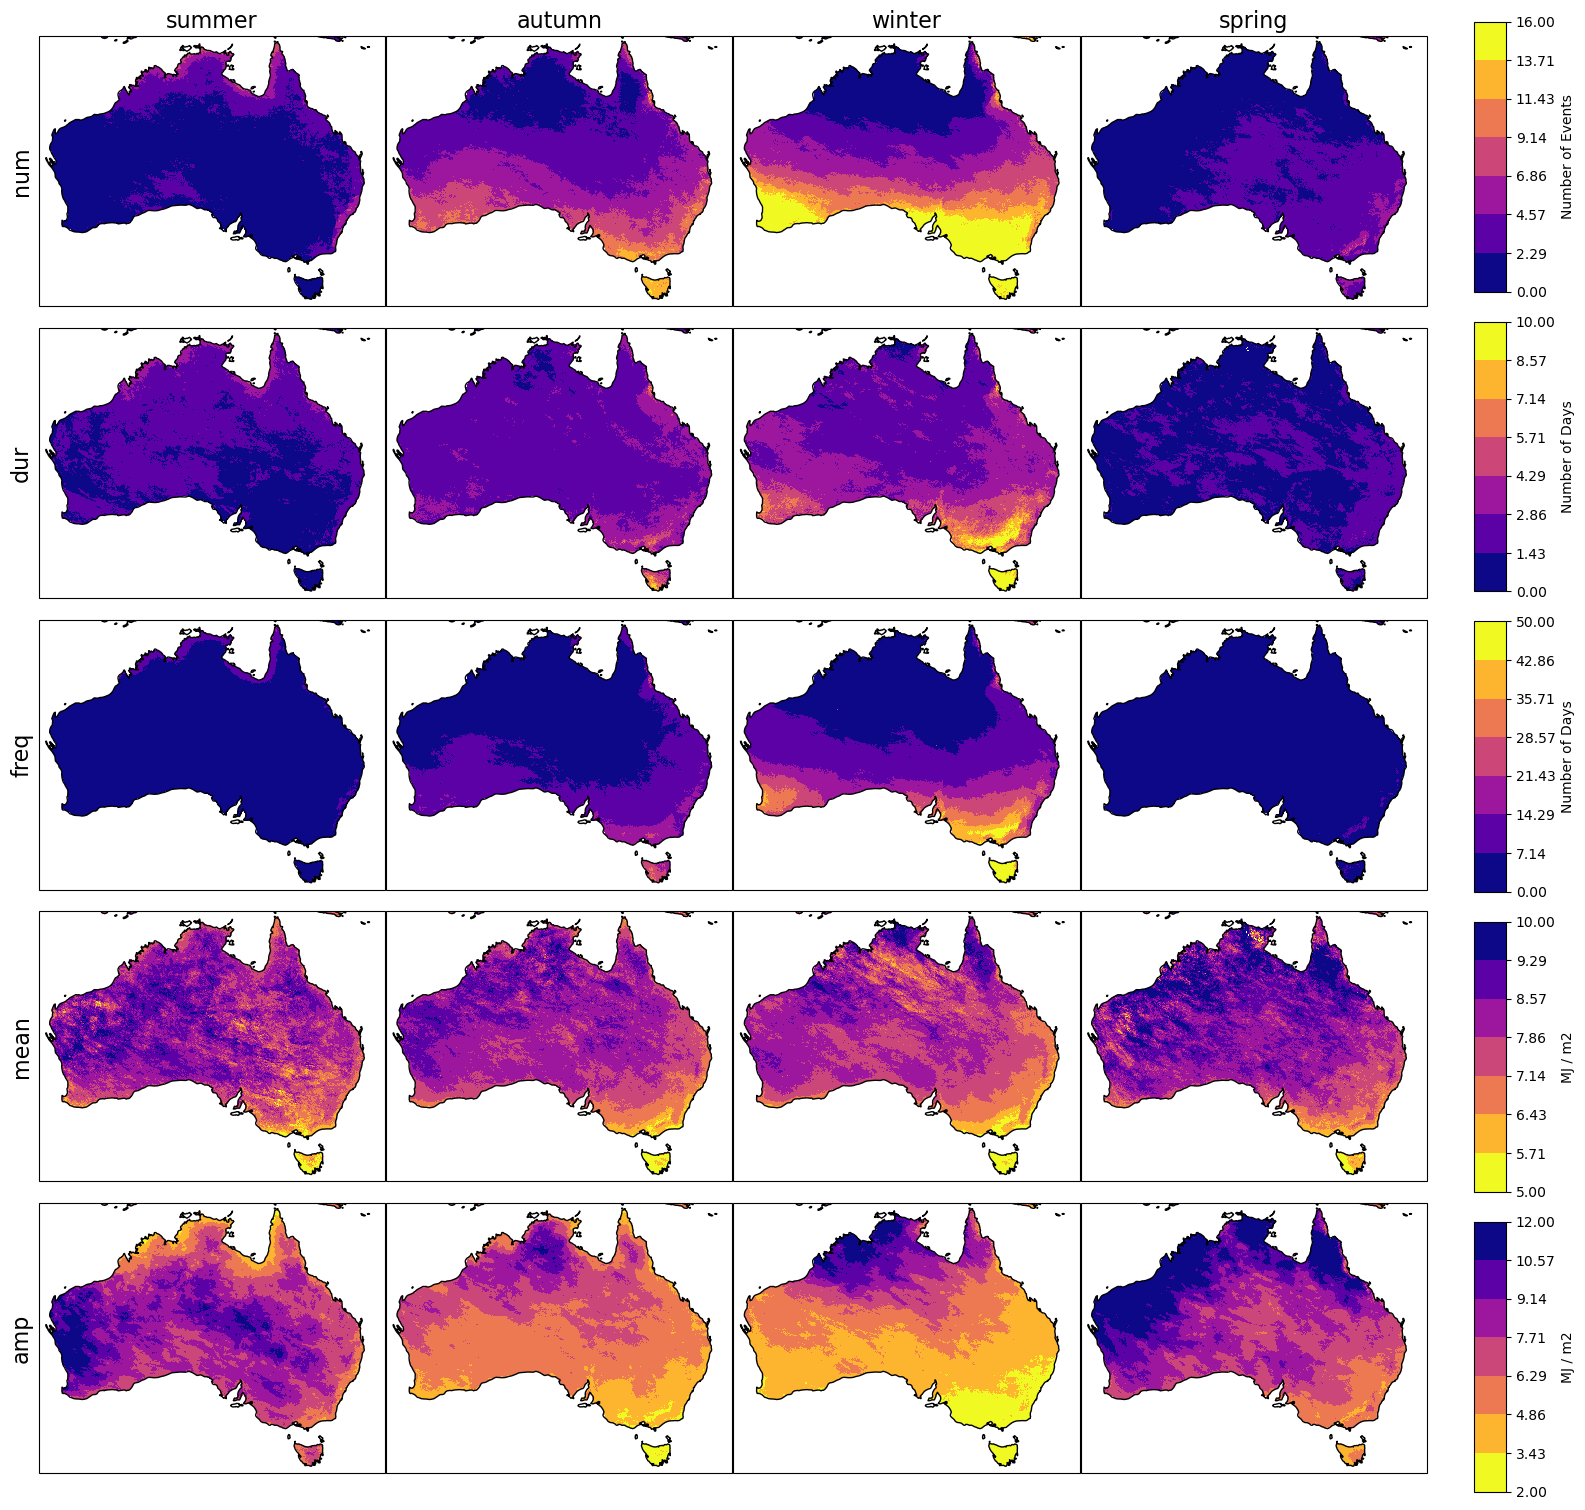

In [28]:
# Start plotting
fig, axes = plt.subplots(
    nrows=len(variables), ncols=len(seasons),
    figsize=(4 * len(seasons), 3 * len(variables)),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

v_vals = {
    'freq': (0,50),
    'amp': (2,12),
    'num': (0,16),
    'dur': (0,10),
    'mean': (5,10)
}

cbar_labels = {
    'freq': 'Number of Days',
    'amp': 'MJ / m2',
    'num': 'Number of Events',
    'dur': 'Number of Days',
    'mean': 'MJ / m2'
}

for i, var in enumerate(variables):
    # Define bin edges for discrete coloring
    da_all = ds[var]
    vmin = v_vals[var][0]
    vmax = v_vals[var][1]
    bins = np.linspace(vmin, vmax, 8)  # 7 bins
    if var in ['mean', 'amp']:
        cmap = get_cmap('plasma_r', len(bins) - 1)
    else:
        cmap = get_cmap('plasma', len(bins) - 1)
    norm = mcolors.BoundaryNorm(bins, ncolors=cmap.N)

    for j, season in enumerate(seasons):
        ax = axes[i, j]
        data = ds[var].sel(season=season) #.squeeze()
        land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(data)
        da_plot = data.where(land_mask == 0)

        if i == 0:
            ax.set_title(season, fontsize=16)
        if j == 0:
            ax.set_ylabel(var, fontsize=16)

        mesh = ax.pcolormesh(
            da_plot['longitude'].values,
            da_plot['latitude'].values,
            da_plot.values,
            cmap=cmap, norm=norm, shading='auto',
            transform=ccrs.PlateCarree()
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.set_xticks([])
        ax.set_yticks([])

    # Add shared colorbar for this metric (row)
    cbar_ax = fig.add_axes([
        0.92,                     # x-position (pushes cbar to the right)
        (len(variables) - i - 1) * 0.2,  # y-position per row
        0.02,                     # width of cbar
        0.18                     # height (matches subplot height)
    ])
    cbar = fig.colorbar(mesh, cax=cbar_ax, ticks=bins, spacing='proportional')
    cbar.ax.set_yticklabels([f'{b:.2f}' for b in bins])
    cbar.set_label(cbar_labels[var])

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig(f'{fig_dir}metric_map.png')
plt.show()